In [1]:
# import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os 

color_pal = sns.color_palette() 
plt.style.use('fivethirtyeight')

In [5]:
# create our database engine
load_dotenv()
engine = create_engine(os.getenv("connection_string"), connect_args={
        "ssl": {
            "ssl_ca": "/etc/ssl/certs/ca-certificates.crt",
        }
    })

In [4]:
with engine.connect() as conn:
  query = text("""SELECT YEAR, COUNT(*)
                FROM totalcrime
                GROUP BY year
                ORDER BY YEAR ASC""")
  
  crime_by_year = pd.read_sql_query(query, conn)

In [5]:
print(crime_by_year)

    YEAR  count(*)
0   2010    199505
1   2011    196714
2   2012    199090
3   2013    191142
4   2014    174336
5   2015    208454
6   2016    224003
7   2017    229976
8   2018    229068
9   2019    218961
10  2020    191176
11  2021    206824
12  2022    233003
13  2023    119200


In [6]:
crime_by_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   YEAR      14 non-null     int64
 1   count(*)  14 non-null     int64
dtypes: int64(2)
memory usage: 352.0 bytes


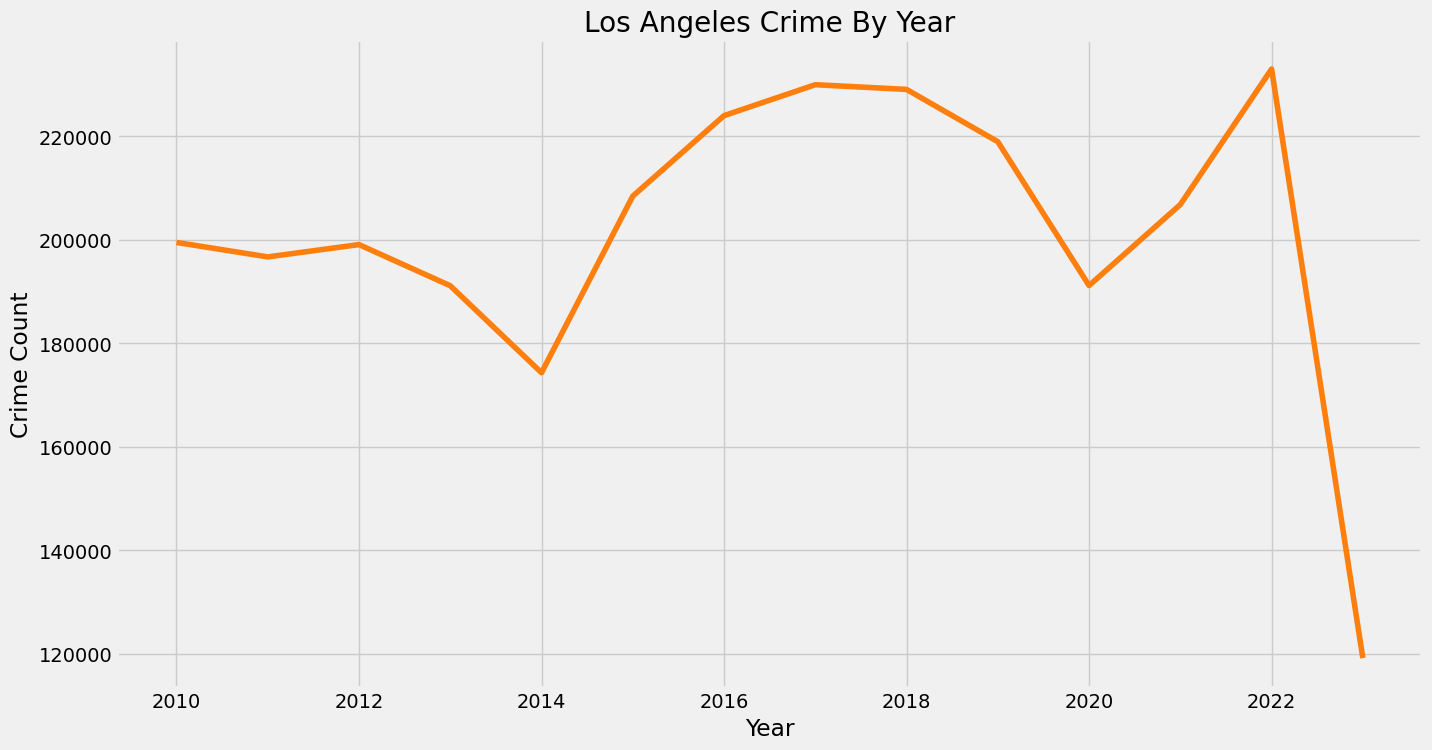

In [7]:
# Los Angeles Crime from 2010 to 2023
plt.figure(figsize=(15,8))
sns.lineplot(data = crime_by_year, x = "YEAR", y = "count(*)", color = color_pal[1])
plt.title("Los Angeles Crime By Year")
plt.ylabel("Crime Count")
plt.xlabel("Year")
plt.show()

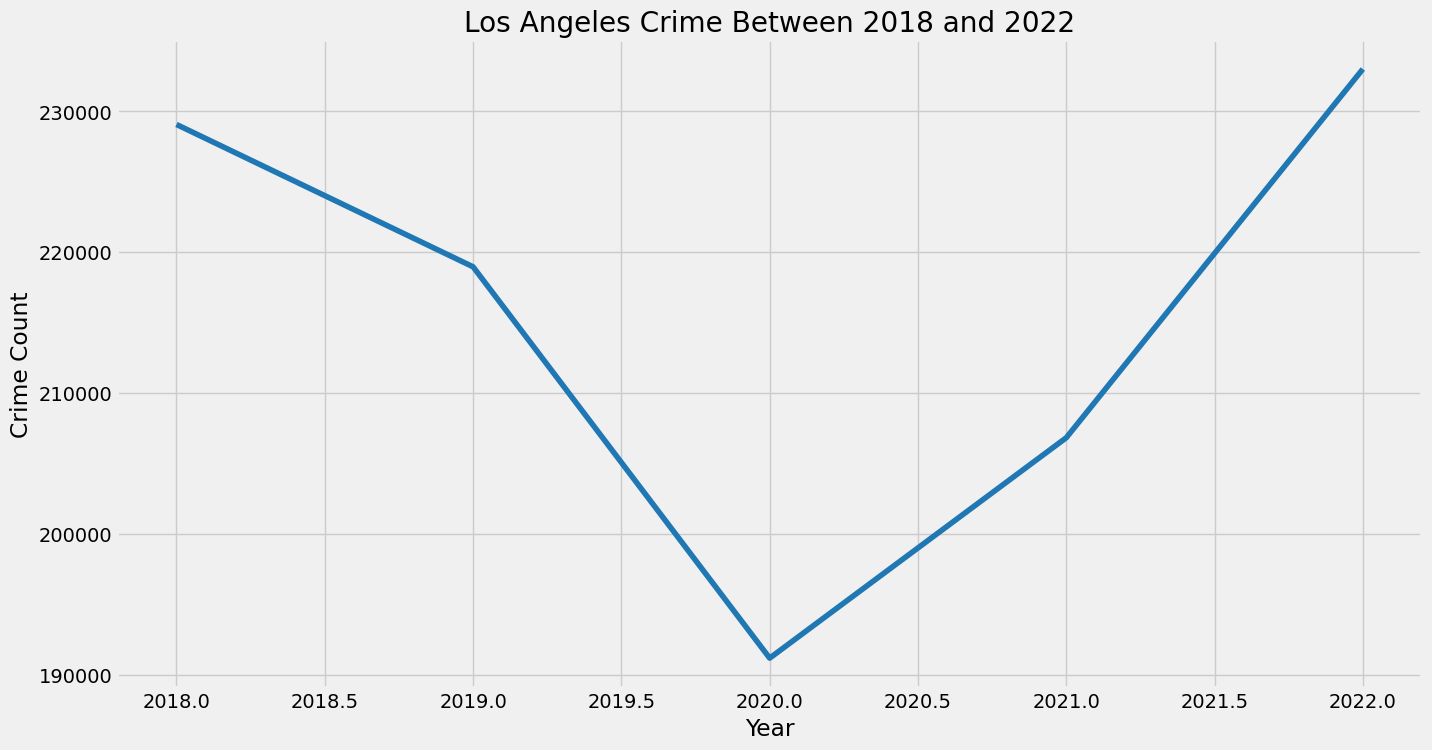

In [8]:
crime_22 = crime_by_year.loc[crime_by_year['YEAR'].isin([2019,2018,2020,2021,2022])]
plt.figure(figsize=(15,8))
sns.lineplot(data = crime_22, x = "YEAR", y = "count(*)", color = color_pal[0])
plt.title("Los Angeles Crime Between 2018 and 2022")
plt.ylabel("Crime Count")
plt.xlabel("Year")
plt.show()

In [10]:
with engine.connect() as conn:
  # Crime count per AREA 2010-2023
  area_crime_query = text("""
                          SELECT AREA_NAME, COUNT(*) as COUNT
                          FROM totalcrime
                          GROUP BY AREA_NAME
                          ORDER BY COUNT(*) DESC""")
  
  # CRIME COUNT PER AREA IN 2020-2023
  area_2022_query = text("""
                          SELECT AREA_NAME, COUNT(*) as COUNT
                          FROM totalcrime
                          WHERE YEAR IN (2020,2021,2022,2023)
                          GROUP BY AREA_NAME
                          ORDER BY COUNT(*) DESC""")
  
  area_crime = pd.read_sql_query(area_crime_query, conn)
  area_2022 = pd.read_sql_query(area_2022_query, conn)

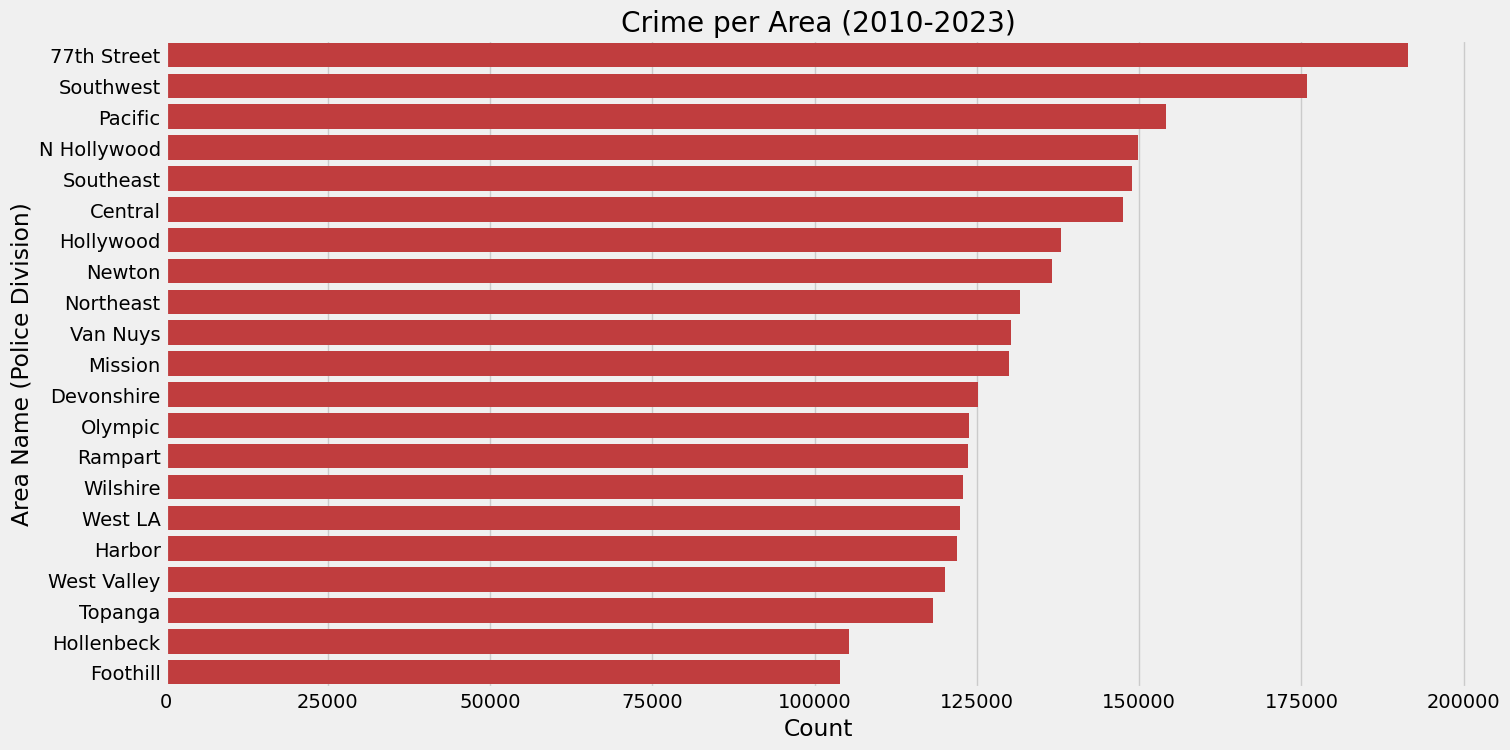

In [11]:
plt.figure(figsize=(15,8))
sns.barplot(data = area_crime, y = "AREA_NAME", x = "COUNT", color = color_pal[3])
plt.title("Crime per Area (2010-2023)")
plt.ylabel("Area Name (Police Division)")
plt.xlabel("Count")
plt.show()

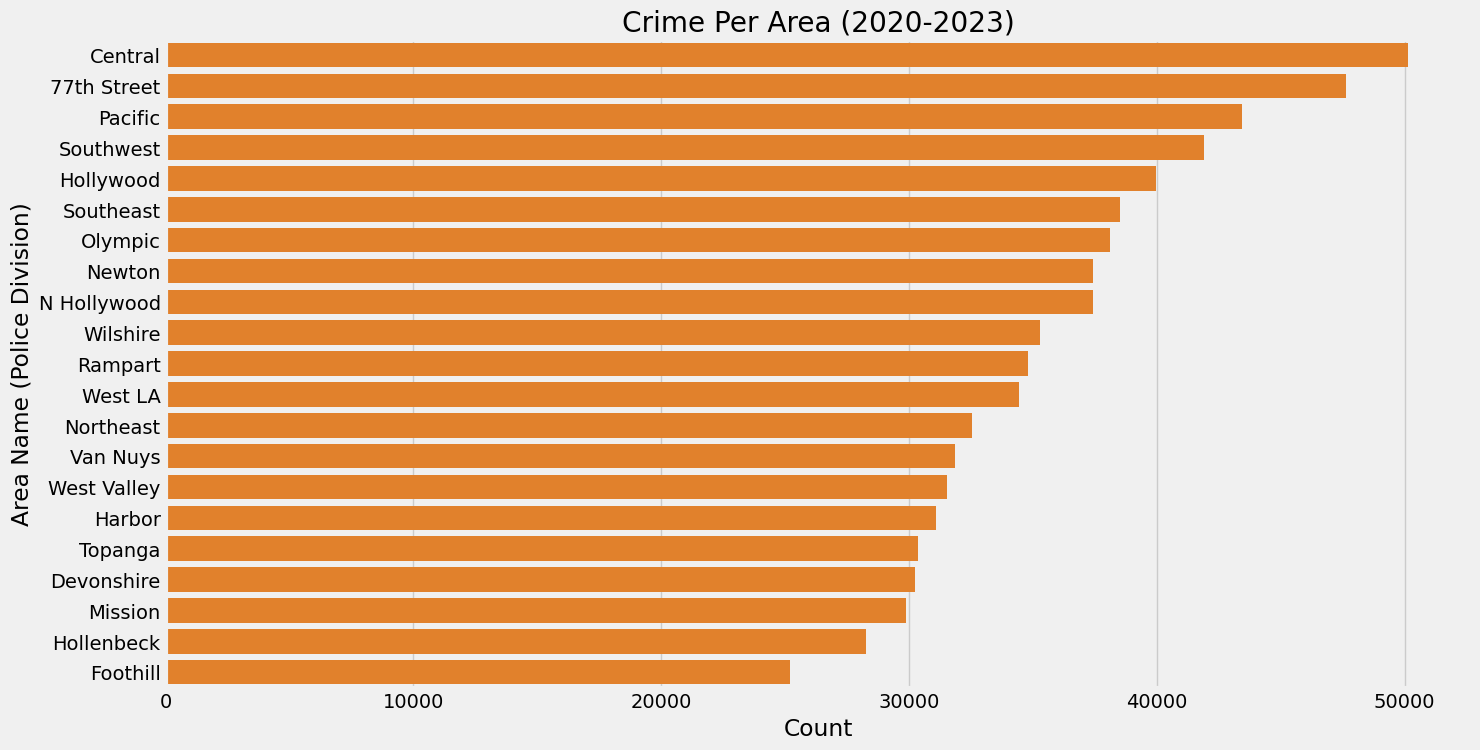

In [12]:
plt.figure(figsize=(15,8))
sns.barplot(data = area_2022, y = "AREA_NAME", x = "COUNT", color = color_pal[1])
plt.title("Crime Per Area (2020-2023)")
plt.ylabel("Area Name (Police Division)")
plt.xlabel("Count")
plt.show()

In [13]:
with engine.connect() as conn:
  # CRIME COUNT BY YEAR AND BY AREA NAME 
  area_year_query = text("""
                          SELECT YEAR, AREA_NAME, COUNT(*) as COUNT
                          FROM totalcrime
                          GROUP BY YEAR, AREA_NAME
                          ORDER BY YEAR ASC, COUNT(*) DESC""")
  
  # CHECK CRIME IN THE LAST 5 YEARS BY QUARTER TO SEE IF CRIME IS SEASONAL
  year_quarter_query = text("""
                          SELECT YEAR, QUARTER, COUNT(*) as COUNT
                          FROM totalcrime
                          WHERE YEAR BETWEEN 2018 AND 2023
                          GROUP BY YEAR, QUARTER
                          ORDER BY YEAR ASC, COUNT(*) DESC""")
  
  area_year = pd.read_sql_query(area_year_query, conn)
  year_quarter_crime = pd.read_sql_query(year_quarter_query, conn)

<Axes: xlabel='AREA_NAME'>

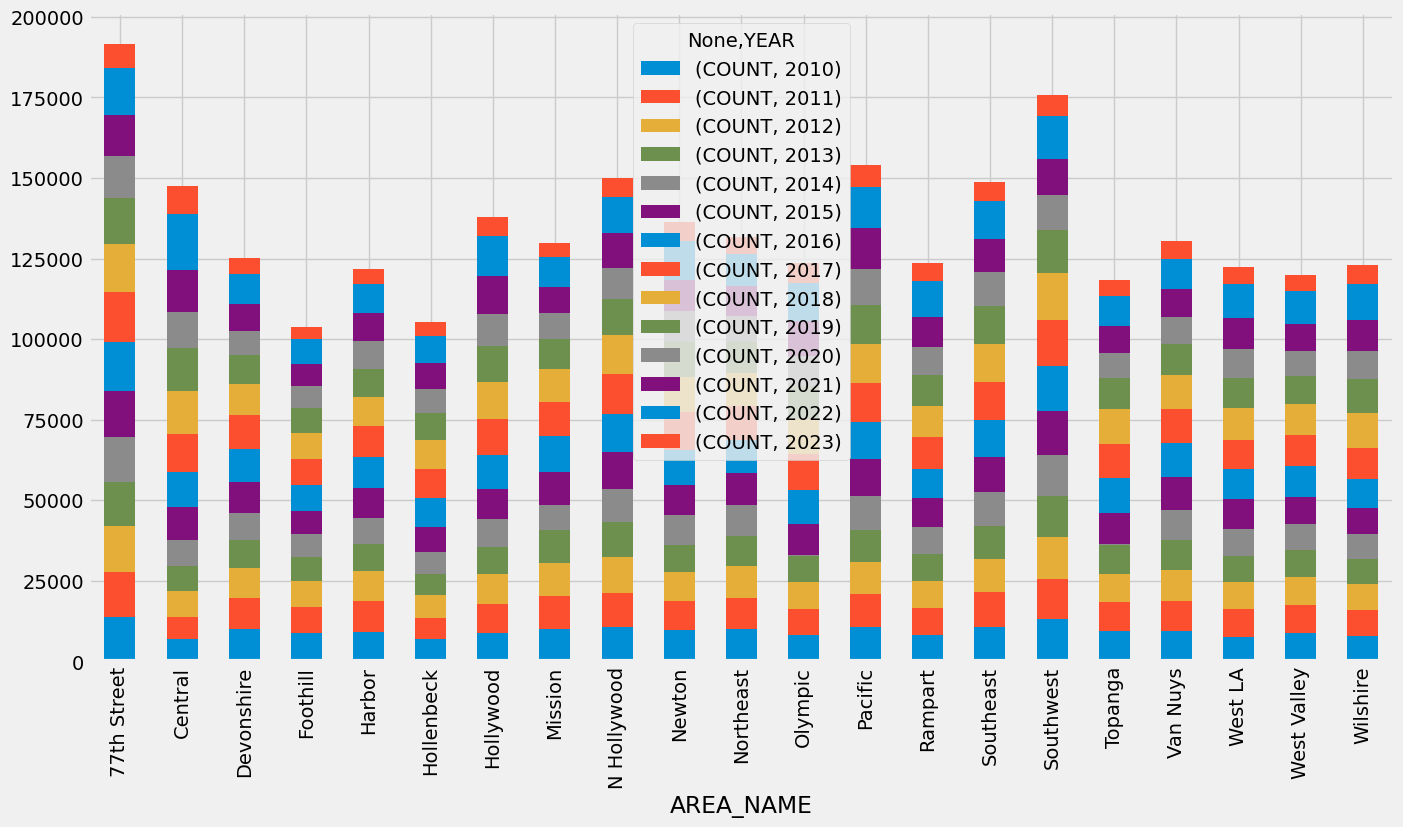

In [14]:
area_year_pivot = area_year.pivot_table(index="AREA_NAME", columns = "YEAR")

area_year_pivot.plot(kind='bar', stacked = True, figsize = (15,8))

In [15]:
area_year

,YEAR,AREA_NAME,COUNT
0,2010,77th Street,13846
1,2010,Southwest,13091
2,2010,N Hollywood,10833
3,2010,Southeast,10603
4,2010,Pacific,10588
...,...,...,...
289,2023,Topanga,4891
290,2023,Harbor,4726
291,2023,Mission,4559
292,2023,Hollenbeck,4309


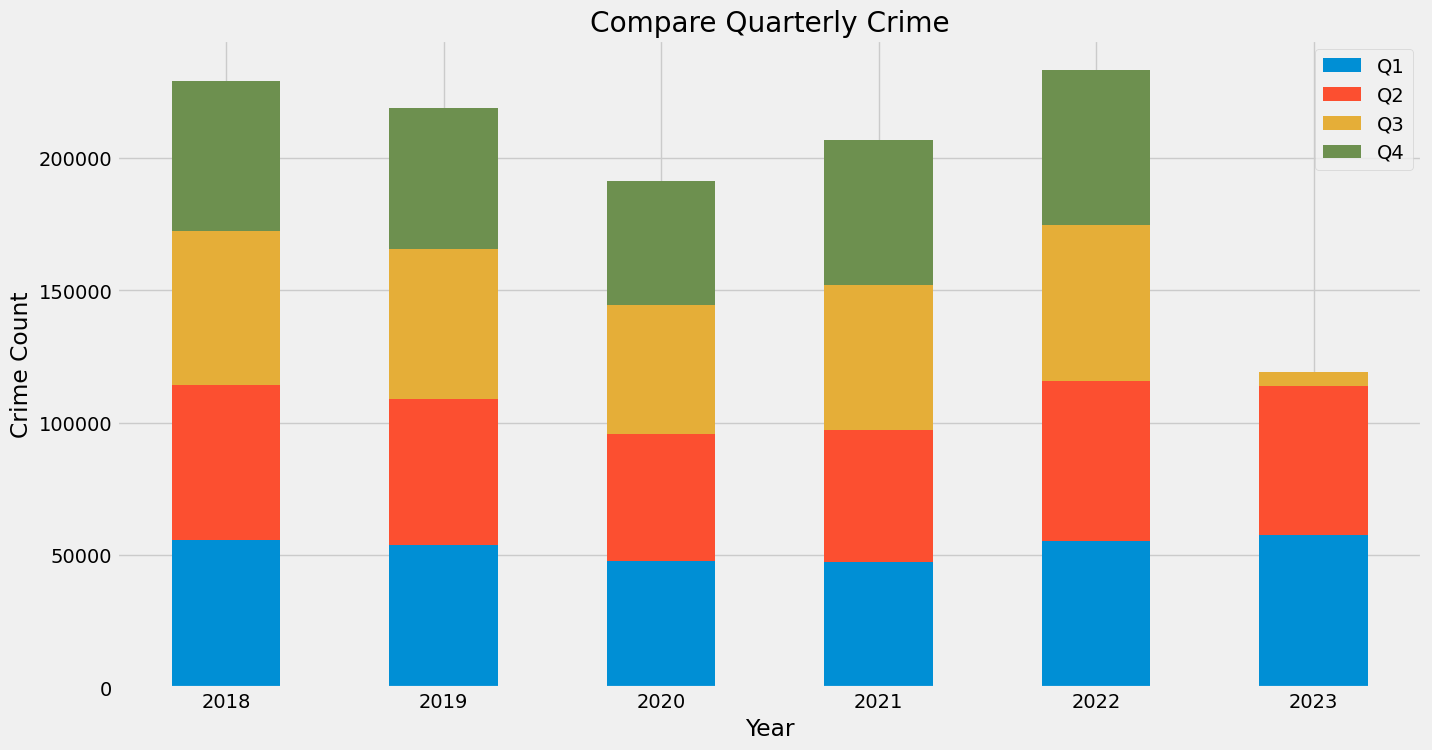

In [23]:
df = year_quarter_crime.copy()

df_pivot = df.pivot_table(index = "YEAR", columns = "QUARTER")
df_pivot.plot(kind='bar', stacked = True,  figsize = (15,8))
plt.title("Compare Quarterly Crime")
plt.ylabel("Crime Count")
plt.xlabel("Year")
plt.xticks(rotation = 360)
plt.legend(['Q1','Q2','Q3','Q4'])

In [24]:
with engine.connect() as conn:
  #  WHAT TYPE OF CRIME WAS THE MOST PREVALENT
  crime_type_query = text("""
                      SELECT CRM_CD_DESC, COUNT(*) as COUNT
                      FROM totalcrime
                      GROUP BY CRM_CD_DESC
                      ORDER BY COUNT(*) DESC
                      LIMIT 15 """)
  
  # WHAT TYPE OF CRIME WAS THE MOST PREVALENT IN THE LAST FIVE YEARS - Top 10
  crime_top_query = text("""
                      SELECT CRM_CD_DESC, COUNT(*) as COUNT
                      FROM totalcrime
                      WHERE YEAR BETWEEN 2018 AND 2023
                      GROUP BY CRM_CD_DESC
                      ORDER BY COUNT(*) DESC
                      LIMIT 10 """)
  
  crime_type = pd.read_sql_query(crime_type_query, conn)
  crime_top = pd.read_sql_query(crime_top_query, conn)

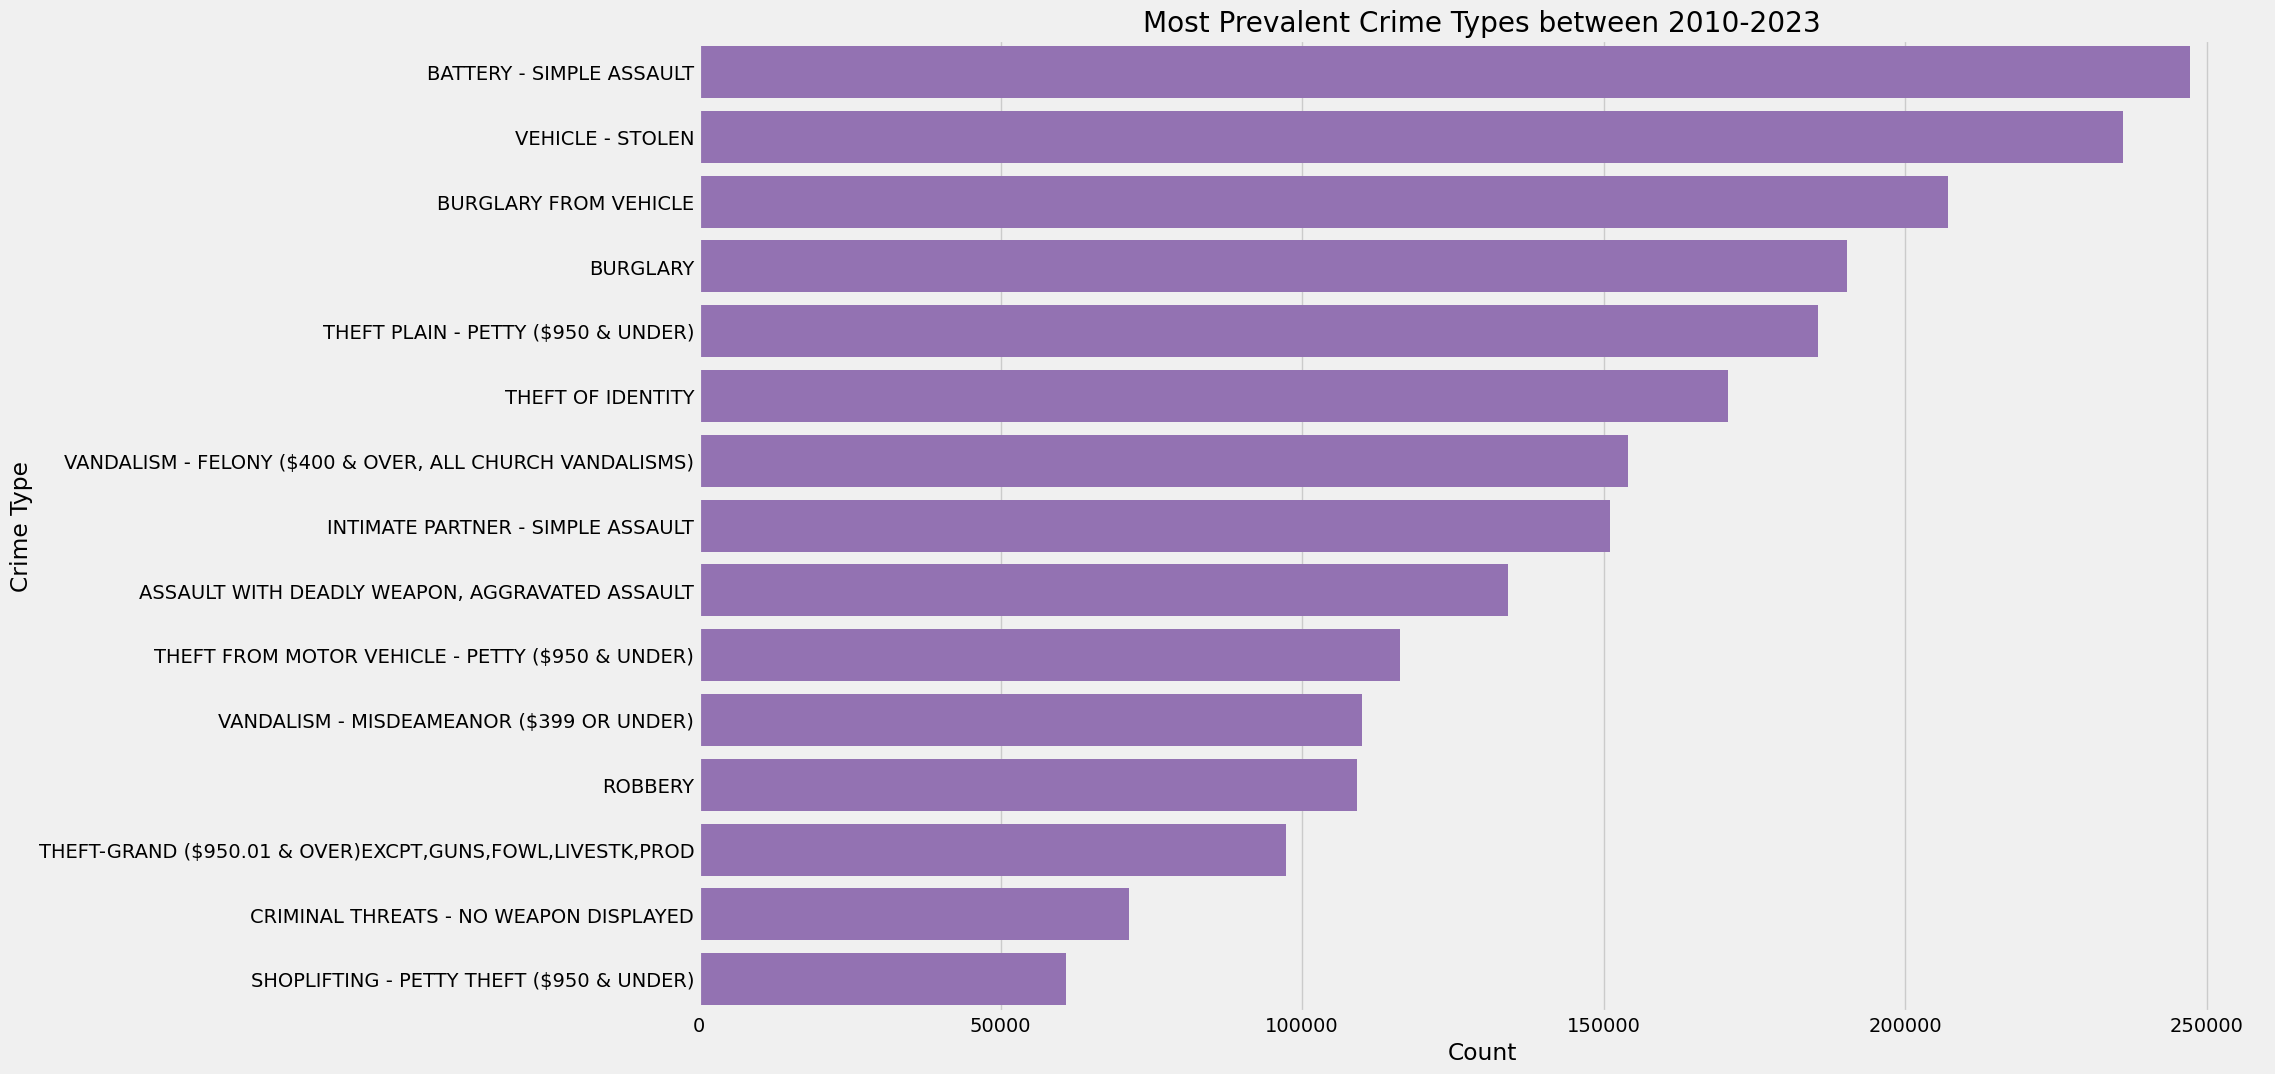

In [26]:
plt.figure(figsize=(18,12))
sns.barplot(data = crime_type, y = "CRM_CD_DESC", x = "COUNT", color = color_pal[4])
plt.title("Most Prevalent Crime Types between 2010-2023")
plt.ylabel("Crime Type")
plt.xlabel("Count")
plt.show()

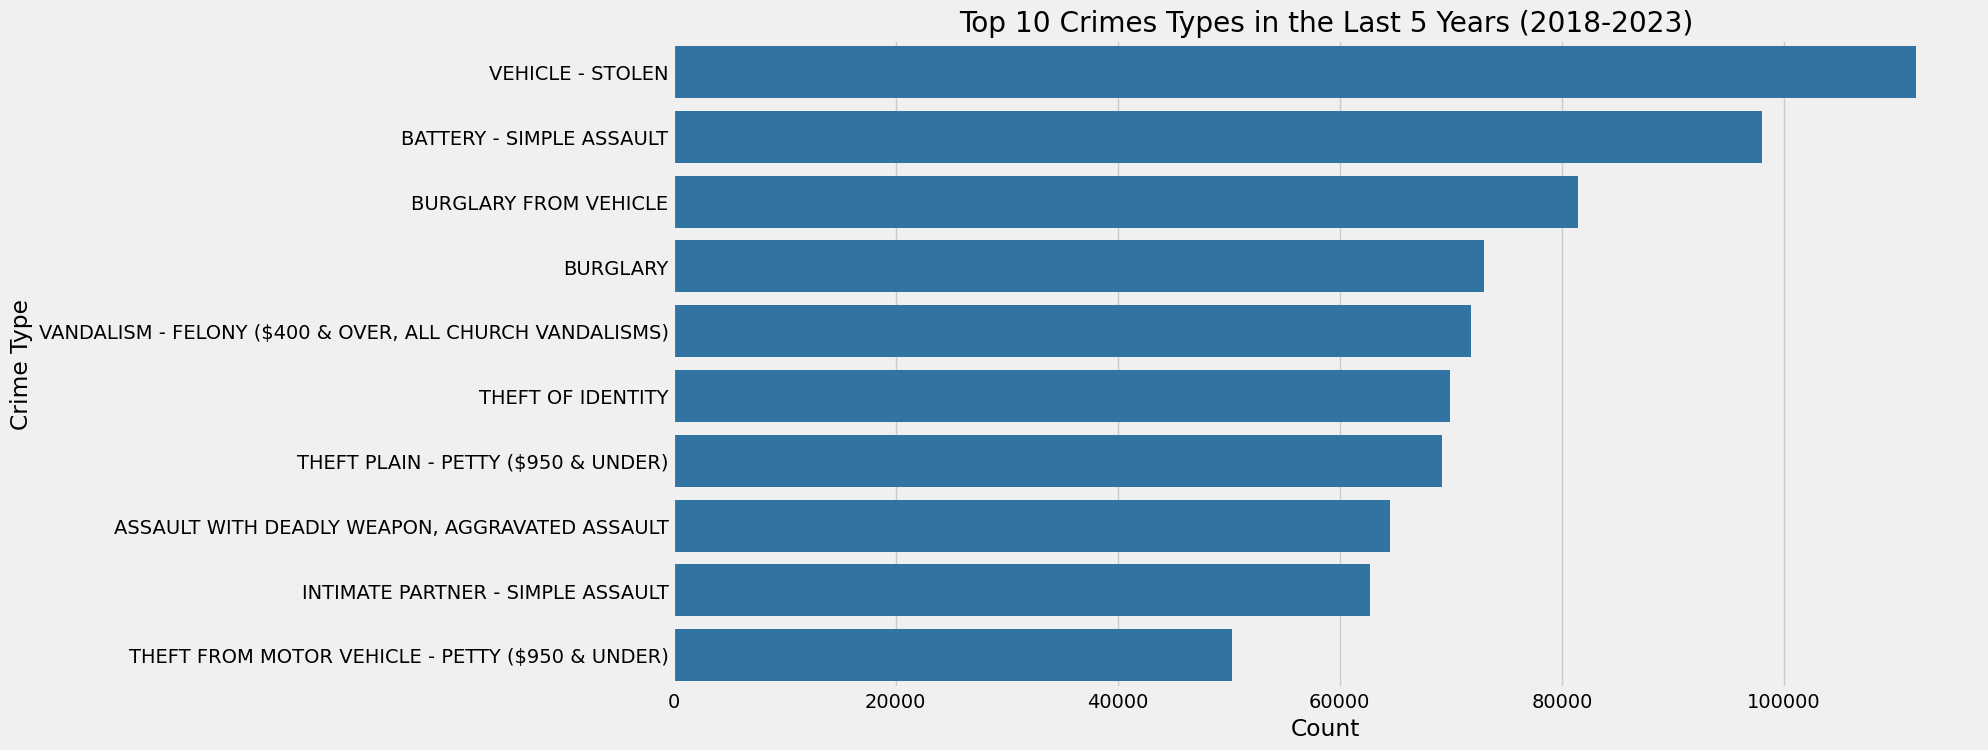

In [27]:
plt.figure(figsize=(15,8))
sns.barplot(data = crime_top, y = "CRM_CD_DESC", x = "COUNT", color = color_pal[0])
plt.title("Top 10 Crimes Types in the Last 5 Years (2018-2023)")
plt.ylabel("Crime Type")
plt.xlabel("Count")
plt.show()

In [28]:
with engine.connect() as conn:
  # victim average age by enthicity between 2018 and 2023
  vict_avg_query = text("""
                          SELECT VICT_DESCENT, AVG(VICT_AGE) as AVG
                          FROM totalcrime
                          WHERE YEAR BETWEEN 2018 AND 2023
                          GROUP BY VICT_DESCENT """)
  
  # Victim sex crime count between the years 2018 and 2023
  vict_sex_query = text("""
                          SELECT VICT_SEX, COUNT(*) as COUNT
                          FROM totalcrime
                          WHERE YEAR BETWEEN 2018 AND 2023
                          GROUP BY VICT_SEX """)
                            
  vict_avg = pd.read_sql_query(vict_avg_query, conn)
  vict_sex = pd.read_sql_query(vict_sex_query, conn)

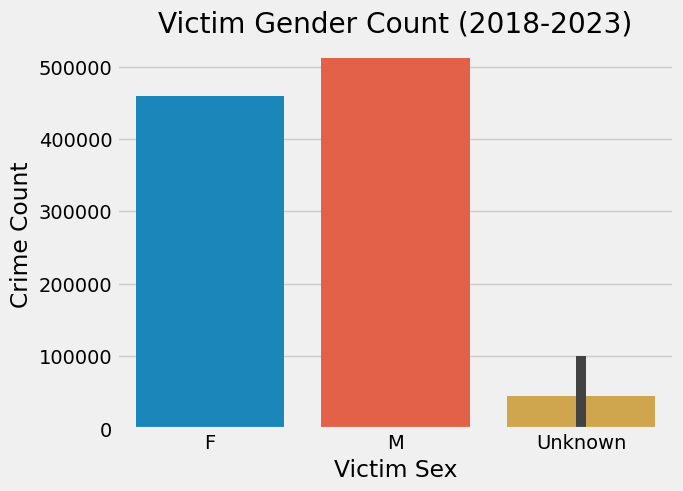

In [29]:
df = vict_sex.replace(['H','N','-','','X'],'Unknown')

sns.barplot(data=df, x = "VICT_SEX", y = "COUNT")
plt.title("Victim Gender Count (2018-2023)")
plt.xlabel("Victim Sex")
plt.ylabel("Crime Count")
plt.show()

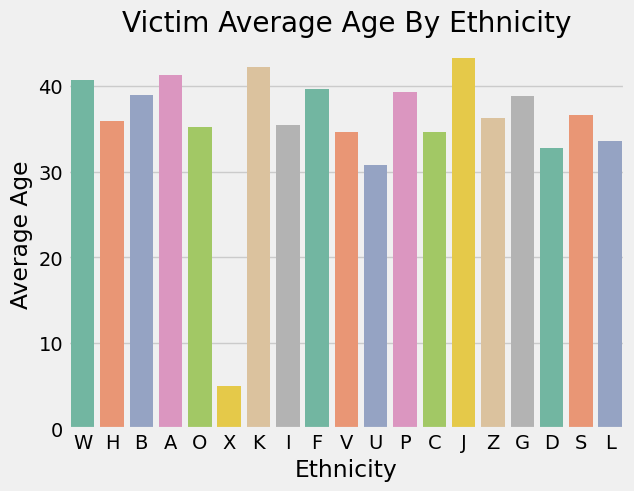

In [44]:
df = vict_avg.loc[~vict_avg['VICT_DESCENT'].isin(['','-'])]

sns.barplot(data = df, x = "VICT_DESCENT", y = "AVG", palette = 'Set2')
plt.title("Victim Average Age By Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Average Age")
plt.show()

In [31]:
Descent_dict = {"Descent Code":['A','B','C','D','F','G','H','I','J','K','L','O','P','S','U','V','W','X','Z'],
            "Name":['Other Asian','Black','Chinese','Cambodian','Filipino','Guamanian','Hispanic/Latin/Mexican',
                  'American Indian/Alaskan Native','Japanese','Korean','Laotian','Other', 'Pacific Islander',
                  'Samoan','Hawaiian','Vietnamese','White','Unknown','Asian Indian']}

Descent = pd.DataFrame(Descent_dict)
Descent

,Descent Code,Name
0,A,Other Asian
1,B,Black
2,C,Chinese
3,D,Cambodian
4,F,Filipino
5,G,Guamanian
6,H,Hispanic/Latin/Mexican
7,I,American Indian/Alaskan Native
8,J,Japanese
9,K,Korean


In [34]:
# library to save a data frame as an image
import dataframe_image as dfi

In [35]:
# save a data frame into an image
# dfi.export(Descent,"Descent.png")

In [18]:
plt.style.use('bmh')

In [3]:
# query function connected to our database engine
def query(statement):
  with engine.connect() as conn:
    query = text(statement)
    df = pd.read_sql_query(query, conn)
    return df

In [6]:
# shoplifting analysis
shop_under_950 = query("""
                        SELECT YEAR, COUNT(*) AS COUNT
                        FROM totalcrime
                        WHERE CRM_CD_DESC = "SHOPLIFTING - PETTY THEFT ($950 & UNDER)"
                        GROUP BY YEAR
                        ORDER BY YEAR ASC """)

shop_under_950.head()

,YEAR,COUNT
0,2010,3015
1,2011,3357
2,2012,3684
3,2013,3549
4,2014,3536


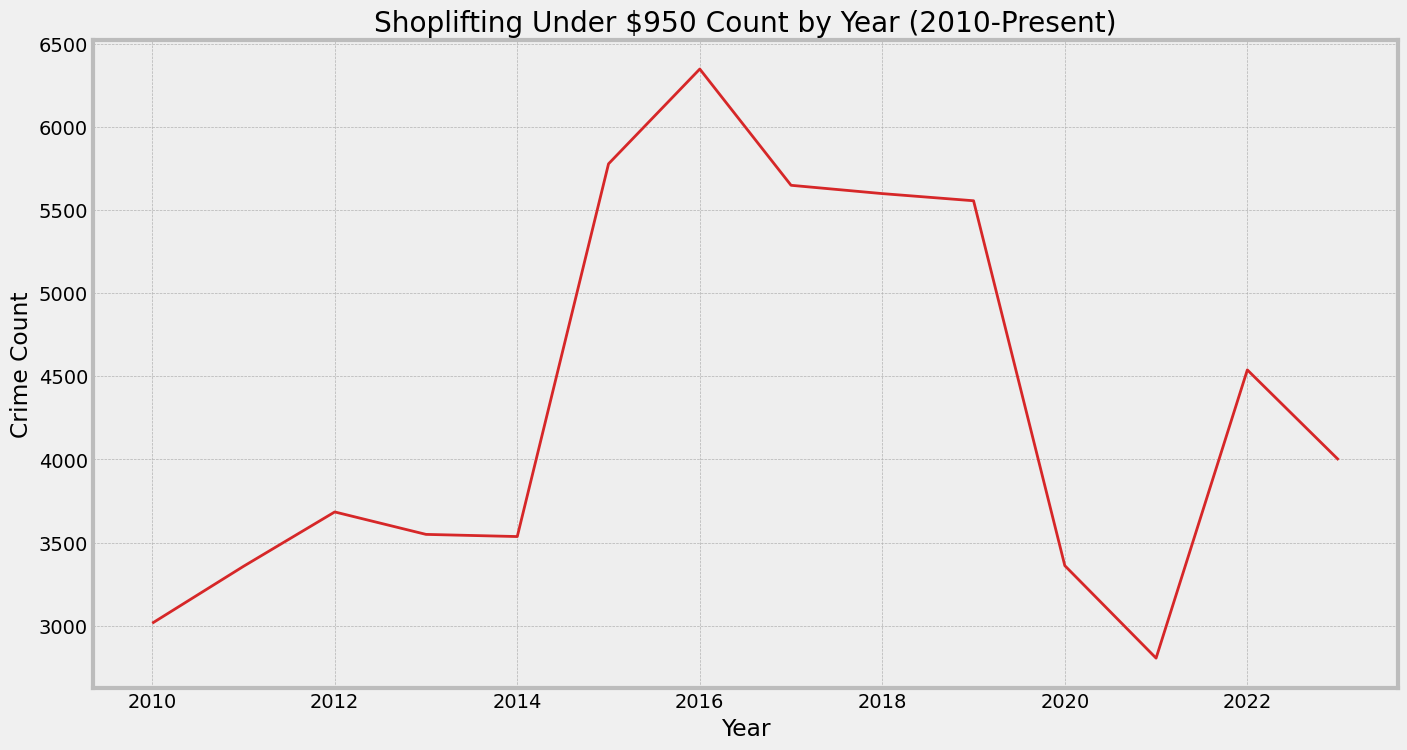

In [19]:
plt.figure(figsize=(15,8))
sns.lineplot(data = shop_under_950, y = "COUNT", x = "YEAR", color = color_pal[3])
plt.title("Shoplifting Under $950 Count by Year (2010-Present)")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.show()

In [9]:
shop_over_951 = query(""" 
                      SELECT YEAR, COUNT(*) AS COUNT
                      FROM totalcrime
                      WHERE CRM_CD_DESC = "SHOPLIFTING-GRAND THEFT ($950.01 & OVER)"
                      GROUP BY YEAR
                      ORDER BY YEAR ASC """)

shop_over_951

,YEAR,COUNT
0,2010,463
1,2011,204
2,2012,180
3,2013,163
4,2014,188
5,2015,432
6,2016,537
7,2017,572
8,2018,814
9,2019,963


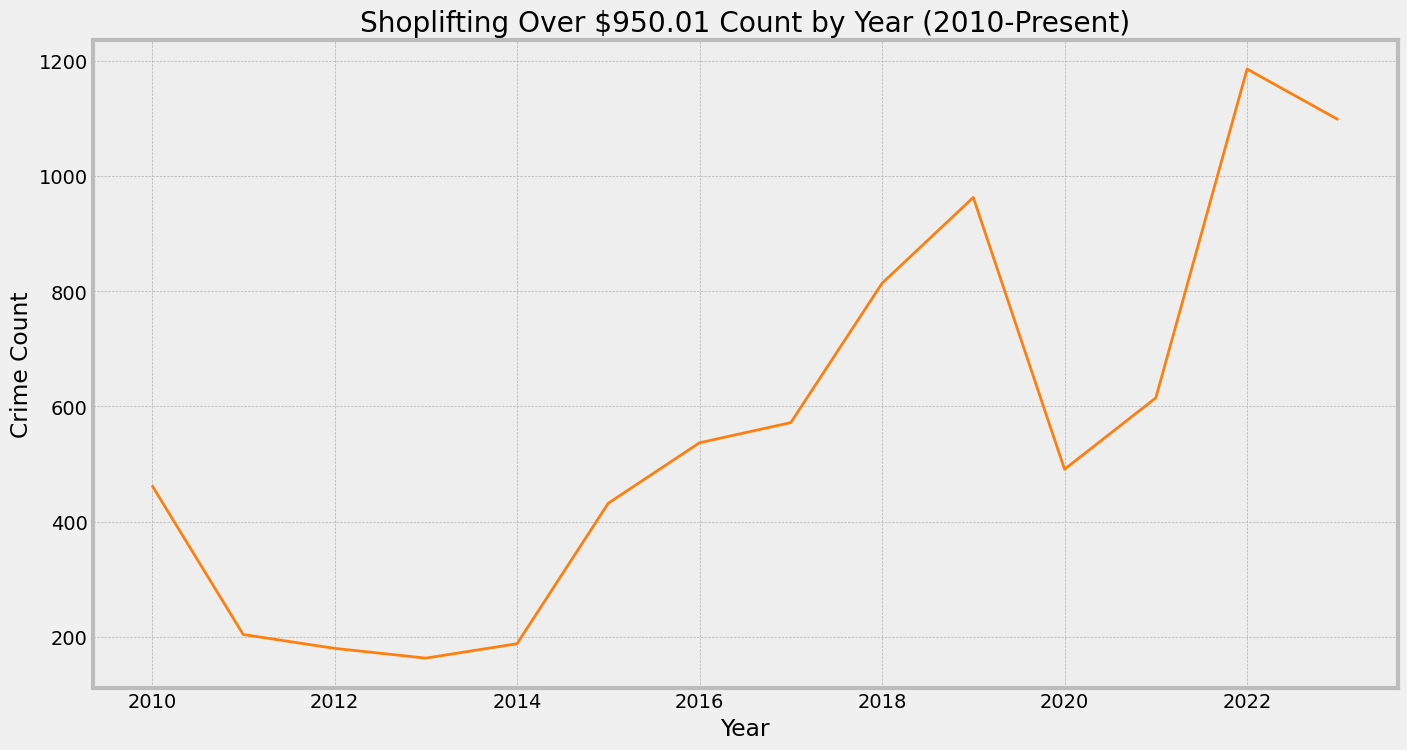

In [20]:
plt.figure(figsize=(15,8))
sns.lineplot(data = shop_over_951, y = "COUNT", x = "YEAR", color = color_pal[1])
plt.title("Shoplifting Over $950.01 Count by Year (2010-Present)")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.show()